In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import PIL

torch.__version__

'1.10.2'

In [2]:
import numpy as np
import random
import os
from tqdm import tqdm
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import time

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
!nvidia-smi

Tue Mar  1 17:14:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.49       Driver Version: 496.49       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   37C    P8    13W /  N/A |    153MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
train_dataset = torchvision.datasets.ImageFolder('train/' + 'train') # загрузили данные трейн

In [5]:
len(train_dataset)

100000

Нарисуем несколько рандомных картинок из тренировочной выборки. 

In [6]:
class_names = train_dataset.classes # забираем метки классов

In [9]:
len(class_names)

200

In [12]:
type(train_dataset)

torchvision.datasets.folder.ImageFolder

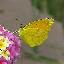

In [63]:
# картинки 64х64
train_dataset[0][0]

In [15]:
train_dataset[0][1]

0

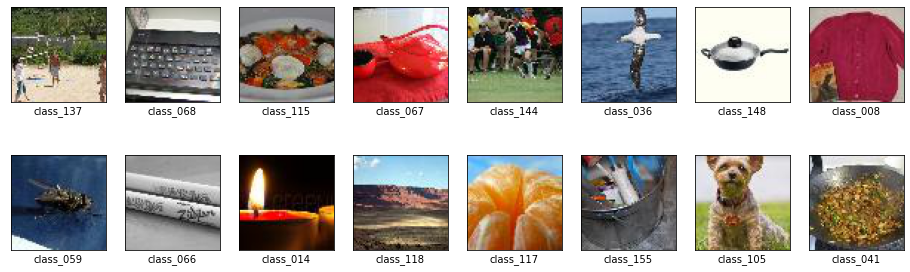

In [16]:
# отрисуем все что у нас есть
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(train_dataset))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(train_dataset[random_index][0])
        ax.set_xlabel(class_names[train_dataset[random_index][1]])
plt.show()

In [4]:
# Смотрим что у нас там по девайсам
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [5]:
DEVICE

'cuda:0'

In [6]:
RANDOM_SEED = 1234
torch.manual_seed(RANDOM_SEED)

In [7]:
batch_size = 1024 # Выбираем размер батча
num_workers = 6

transform = torchvision.transforms.Compose([ 
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = torchvision.datasets.ImageFolder('train/' + 'train', transform) # загрузили данные

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [90000, 10000])

trainloader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers,
                                          pin_memory=True)

valloader = torch.utils.data.DataLoader(val_dataset, # Возможно не оптимально :)
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=num_workers,
                                        pin_memory=True)

In [8]:
class CNN(nn.Module):
    def __init__(self): 
        super().__init__()
        self.classifier = nn.Sequential(nn.Conv2d(in_channels=3,
                                                  out_channels=18,
                                                  kernel_size=(5,5),
                                                 padding=(2,2)), # 64x64
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=(2,2),
                                                    stride=(2,2)), # 32x32
                                        nn.Conv2d(in_channels=18,
                                                  out_channels=50,
                                                  kernel_size=(5,5),
                                                 padding=(2,2)), # 32x32
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=(2,2),
                                                    stride=(2,2)), # 16x16
                                        nn.Conv2d(in_channels=50,
                                                 out_channels=80,
                                                 kernel_size=(5,5),
                                                 padding=(2,2)), # 16x16
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=(2,2),
                                                    stride=(2,2)), # 8x8
                                        nn.Conv2d(in_channels=80,
                                                 out_channels=120,
                                                 kernel_size=(5,5),
                                                 padding=(2,2)), # 8x8
                                        nn.Flatten(),
                                        nn.Linear(120*8*8, 2500),
                                        nn.BatchNorm1d(2500),
                                        nn.Dropout(),
                                        nn.ReLU(),
                                        nn.Linear(2500, 700),
                                        nn.BatchNorm1d(700),
                                        nn.ReLU(),
                                        nn.Linear(700, 200),

                                        
                                    )
             
    def forward(self, x):
#         x = x.reshape(x.size(0), -1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1) 
        return logits, probs

In [9]:
model = CNN()
model

CNN(
  (classifier): Sequential(
    (0): Conv2d(3, 18, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(18, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(50, 80, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(80, 120, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=7680, out_features=2500, bias=True)
    (12): BatchNorm1d(2500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Dropout(p=0.5, inplace=False)
    (14): ReLU()
    (15): Linear(in_features=2500, out_features=700, bias=True)
    (16): BatchN

In [10]:
class Main_train_loop():
    def __init__(self, batch_size, trainloader, testloader, Device, model):
        self.batch_size = batch_size
        self.trainloader = trainloader
        self.testloader = testloader
        self.device = Device
        self.model = model
        self.loss_arr = []
        self.loss_arr_test = []
        self.f_arr = []
        self.f_arr_test = []
        
    def get_part_train_loop(self, opt_type='Adam', lr=1e-2, p: dict = dict()):
        self.loss_fn = nn.CrossEntropyLoss()
        if opt_type == 'SGD':
            self.opt = optim.SGD(self.model.parameters(), lr=lr, **p)
        elif opt_type == 'Adam':
            self.opt = optim.Adam(self.model.parameters(), lr=lr, **p)
        elif opt_type == 'RMSprop':
            self.opt = optim.RMSprop(self.model.parameters(), lr=lr, **p)
        
    def accuracy(self, y_predicts, data_y):
        acc = (y_predicts == data_y).sum().item() / y_predicts.size(0)
        return acc
    
    def train_nn(self, trainloader, model, opt, loss_fn, device):
        running_loss = []
        running_f = []
        model.train()
        
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data # Взятие данных
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            opt.zero_grad()
            outputs, probs = model(inputs)
            y_pred = outputs.argmax(dim=1).cpu()
            loss = loss_fn(outputs, labels)
            loss.backward()
            opt.step()
            
            running_loss.append(loss.item())
            running_f.append(f1_score(labels.cpu(), y_pred, average='macro'))
            
        return model, running_loss, running_f
    
    def eval_nn(self, testloader, model, loss_fn, device):
        running_loss_test = []
        running_f_test = []
        model.eval()
        
        predicts = np.array([])
        
        for i, data in enumerate(testloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs, proba = model(inputs)
            y_pred = outputs.argmax(dim=1).cpu()
            predicts = np.append(predicts, y_pred)
            loss = loss_fn(outputs, labels)
            running_loss_test.append(loss.item())
            running_f_test.append(f1_score(labels.cpu(), y_pred, average='macro'))
        
        return running_loss_test, running_f_test, predicts.astype(int)

    def training_loop(self, max_epochs=20):
      
      for epoch in range(max_epochs):
            start_time = time.time()
            
            self.model, running_loss, running_f = self.train_nn(self.trainloader,
                                                               self.model,
                                                               self.opt,
                                                               self.loss_fn,
                                                               self.device)
            running_loss_test, running_f_test, _ = self.eval_nn(self.testloader,
                                                                  self.model,
                                                                  self.loss_fn,
                                                                  self.device)
            
            self.loss_arr.append(np.mean(running_loss))
            self.loss_arr_test.append(np.mean(running_loss_test))
            self.f_arr.append(np.mean(running_f))
            self.f_arr_test.append(np.mean(running_f_test))
            
            if np.mean(running_f_test) >= np.max(self.f_arr_test):
                self.best_model = deepcopy(self.model)
                self.best_epoch = epoch
                self.best_f_test = np.mean(running_f_test)
            
            duration = time.time() - start_time
            print(f"""EPOCH {epoch} : train_loss: {self.loss_arr[-1]:.5f} train_f1: {self.f_arr[-1]:.5f} 
            test_loss: {self.loss_arr_test[-1]:.5f} test_f1: {self.f_arr_test[-1]:.5f}
            Заняло времени {round(duration,2)} секунд""")
                
    def plot(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.plot(self.loss_arr, label='Train loss')
        ax1.plot(self.loss_arr_test, label='Validation loss')
        ax1.legend()
        ax2.plot(self.f_arr, label='Train f1-score')
        ax2.plot(self.f_arr_test, label='Validation f1-score')
        ax2.legend()

In [11]:
model = CNN() # инициализировали модель
model.to(DEVICE) 
main_loop = Main_train_loop(batch_size, trainloader, valloader, DEVICE, model) # инициализировали обучающий класс
main_loop.get_part_train_loop(lr=1e-3) # добавили оптимизатор в самом классе

In [12]:
main_loop.training_loop(20)

EPOCH 0 : train_loss: 4.44843 train_f1: 0.06140 
            test_loss: 4.03511 test_f1: 0.10167
            Заняло времени 105.49 секунд
EPOCH 1 : train_loss: 3.67993 train_f1: 0.15093 
            test_loss: 3.75104 test_f1: 0.13800
            Заняло времени 95.19 секунд
EPOCH 2 : train_loss: 3.33354 train_f1: 0.20940 
            test_loss: 3.54379 test_f1: 0.17313
            Заняло времени 95.44 секунд
EPOCH 3 : train_loss: 3.09127 train_f1: 0.25130 
            test_loss: 3.34587 test_f1: 0.21012
            Заняло времени 96.38 секунд
EPOCH 4 : train_loss: 2.89079 train_f1: 0.28881 
            test_loss: 3.25079 test_f1: 0.23092
            Заняло времени 95.7 секунд
EPOCH 5 : train_loss: 2.70153 train_f1: 0.32236 
            test_loss: 3.23835 test_f1: 0.24969
            Заняло времени 95.39 секунд
EPOCH 6 : train_loss: 2.52257 train_f1: 0.35727 
            test_loss: 3.13392 test_f1: 0.27000
            Заняло времени 95.25 секунд
EPOCH 7 : train_loss: 2.33870 train_f1: 0

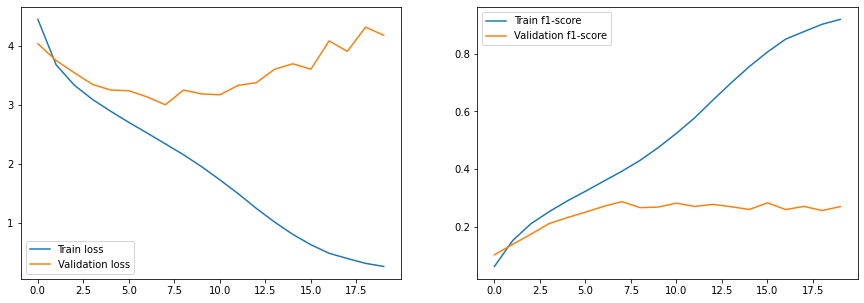

In [13]:
main_loop.plot()

In [14]:
torch.save(main_loop.best_model, 'CNN5_model-.pt')

In [15]:
# Инференс модели на тесте:
best_model = torch.load('CNN5_model.pt')
best_model = best_model.to(DEVICE)
best_model.eval()

CNN(
  (classifier): Sequential(
    (0): Conv2d(3, 18, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(18, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(50, 80, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(80, 120, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=7680, out_features=2500, bias=True)
    (12): BatchNorm1d(2500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Dropout(p=0.5, inplace=False)
    (14): ReLU()
    (15): Linear(in_features=2500, out_features=700, bias=True)
    (16): BatchN

In [16]:
def get_test_dataset():
    images_list = os.listdir('val_kaggle/val_kaggle')
    ids = [s.split('.')[0] for s in images_list]
    
    images = []
    
    for path in images_list:
        image = torchvision.transforms.ToTensor()(PIL.Image.open(f'val_kaggle/val_kaggle/{path}')) # загрузили и конвертнули в тензор
        
        if image.shape[0] == 1: # часть картинок в тесте черно белые
            image = torch.concat([image] * 3) # добавим 3 канала (чтобы сделать чернобелое ргб)
            
        image = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
        
        images.append(image)
    
    return images, ids

In [17]:
def predict(image, best_model):
    image = image[None]
    image = image.to(DEVICE)
    logits, prediction = best_model(image) # прогнозируем
    class_label = torch.argmax(prediction).item()
    return class_label

In [18]:
test_dataset, ids = get_test_dataset()

In [19]:
predict_list = []
for image in tqdm(test_dataset):
    predict_list.append(predict(image, best_model))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 627.28it/s]


In [20]:
import pandas as pd
df_predictions = pd.read_csv('Example_result.csv') # Загрузили пример сабмита

In [21]:
df_predictions['ID'] = ids
df_predictions['Lable'] = predict_list
df_predictions.to_csv('our_first_predict_cnn5-.csv',index=False)